# План работы:
- Первым блоком после заголовка должны быть содержания - уже из них можно собирать структуру курса для Syllabus.md. В качестве эталона - лекция From atoms to nanomaterials
- Сделать взаимодополняющимися разделы "Литература" - Переносить из файла Literature.md в соответствующие разделы и обратно

In [29]:
import matplotlib.pyplot as plt
import os
import json
os.chdir('../course') # Все действия осуществляются из директории курса

from IPython.display import display, Markdown

# Определение путей всех имеющихся в курсе ipynb-файлов

In [30]:
def nb_paths():
    ipynb_paths = []
    for dirname, dirnames, filenames in os.walk(os.getcwd()):
        for filename in filenames:
            if filename.endswith('.ipynb') & (not filename.endswith('-checkpoint.ipynb')):
                ipynb_path = os.path.join(dirname, filename)
                ipynb_paths.append(ipynb_path)
    prefix = len(os.path.commonprefix(ipynb_paths))
    ipynb_paths = [ipynb_path[prefix:] for ipynb_path in ipynb_paths if 'Videos' not in ipynb_path]
    return sorted(ipynb_paths)

# Актуальное содержание в READ.me файле

In [40]:
def chapters(prefix=''):
    chs = dict()
    for i, ipynb_path in enumerate(nb_paths()):
        with open(ipynb_path) as f:
            data = json.load(f)
            name = data['cells'][0]['source'][0]  # Заголовок файла это всегда первая ячейка
            markdown_path = os.path.join(os.path.basename(os.path.dirname(ipynb_path)), os.path.basename(ipynb_path))
            # срез так как название начинается с решетки и пробела
            chs[ipynb_path] = '{0}. [{1}]({2})'.format(i+1, name[2:].strip(), prefix+markdown_path)
    return chs
            
with open('README.md') as f:
    blocks = f.read().split('#')
    for i, block in enumerate(blocks):
        if block.startswith(' Содержание курса'):
            blocks[i] = ' Содержание курса\n\n' + '\n'.join([chapters()[key] for key in sorted(chapters())]) + '\n\n'
    f.close()

with open('README.md', 'w') as f:           
    f.write("#".join(blocks)) 
    f.close()

# Генерация содеражний занятий и полной структуры курса

In [93]:
#! Нужно проверять, есть ли ячейка с содержанием - если есть, то заменять созданной

from urllib.parse import quote
#print(quote('Конспект лекции'.replace(' ', '-')))

for nb_path in nb_paths():
    with open(nb_path) as f:
        data = json.load(f)
        s = ''
        for cell in data['cells']:
            if cell['cell_type'] == 'markdown':
                s += '\n' + '\n'.join(cell['source']) + '\n'
        table = [line[1:].strip() for line in s.split('\n') if line.startswith('#')]
        for line in table:
            print(line.replace('#', 3*' '))

Размерные эффекты и корреляционные радиусы физических явлений
    Краткий исторический экскурс. Наноматериалы без нанотехнологий <a name="history"></a>
    Условный диапазон размеров
    Влияние размеров на химические свойства
       Влияние на реакционную способность
    Доля поверхностных атомов
    Эффект изменения постоянной решетки
       Длина связей в приповерхностном слое
       Термодинамические параметры - темплоемкость, температура плавления, температура Дебая
    Корреляционные радиусы (характеристические длины) физических явлений
       Область пространственного заряда
       Длина экранирования
       Длина свободного пробега
       Длина волны электрона
       Оптические и электронные свойства
       Магнитные свойства
       Механические свойства
       Структура межзеренных границ
       Дефекты в наноматериалах
Контрольные вопросы
Упражнения и задачи
Литература <a name="References"></a>
Электронное строение низкоразмерных структур
Содержание
Конспект лекции
    Метод 

# Генерация страницы с полным списком видео

Для удобства просмотра видео на досуге сделаем общую страницу, в которой видеофрагменты из всех Jupyter-блокнотов будут собираться в общий файл [Videos.md]().

In [43]:
import IPython.nbformat as nbf
from nbconvert.preprocessors import ExecutePreprocessor
ep = ExecutePreprocessor(timeout=600, kernel_name='python3')

md_first_lines = '''
# Видеотека

Данный файл содержит подборку из всех видеофрагментов,
представленных в различных частях курса "Наноматериалы".

Приведенные видеофрагменты не являются обязательными
к просмотру, но позволяют увидеть рассматриваемые проблемы
с позиций других исследователей. Некоторые видеоролики
полезны как примеры лабораторных практик по синтезу
и диагностике различных форм наноматериалов.
'''

videos_path = 'Videos/Videos.ipynb'

with open(videos_path, 'w') as videos_file:
    cells = []
    cells.append(nbf.v4.new_markdown_cell(source=md_first_lines))
    cells.append(nbf.v4.new_code_cell(source='from IPython.lib.display import YouTubeVideo'))
    for nb_path in nb_paths():
        with open(nb_path) as f:
            head = '# {}'.format(chapters(prefix='../')[nb_path])
            cells.append(nbf.v4.new_markdown_cell(source=head))
            data = json.load(f)
            for cell in data['cells']:
                if (cell['cell_type'] == 'code') & ('YouTubeVideo' in ''.join(cell['source'])):
                    d = "".join(cell['source'])
                    d = d.replace('\n', ' ')
                    try:
                        d = d[3:d[d.index("'''")+3:].index("'''")+3]
                        d = d.lstrip()
                    except ValueError:
                        d = '**У этого видео пока нет описания.**'
                    for line in cell['source']:
                        if "YouTubeVideo('" in line.strip():
                            short_link = line[len("YouTubeVideo('"):-len(")'")]
                    v = 'YouTubeVideo("{}")'.format(short_link)
                    cells.append(nbf.v4.new_markdown_cell(source=d))
                    cells.append(nbf.v4.new_code_cell(source=v))
    nb = nbf.v4.new_notebook(cells=cells)
    nbf.write(nb, videos_file)
    os.system('jupyter nbconvert --execute {}'.format(videos_path))

# Общий объем текстовой части

Общий объем непрограммного текста - 239902 символов, что соответствует примерно 133 листов А4.


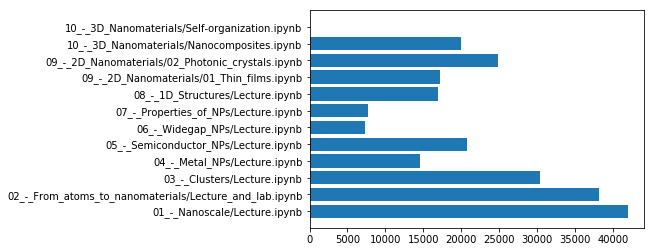

In [44]:
total_symbols = 0
total_symbols =[]

for ipynb_path in sorted(chapters().keys()):
    with open(ipynb_path) as f:
        data = json.load(f)
        symbols = sum([len(''.join(cell['source'])) for cell in data['cells'] if cell['cell_type'] == 'markdown'])
        total_symbols.append(symbols)

        
plt.barh(sorted(chapters().keys()), total_symbols)
print('Общий объем непрограммного текста - {} символов, что соответствует примерно {} листов А4.'.format(sum(total_symbols), sum(total_symbols)//1800))